In [79]:
import numpy as np
np.random.seed(42)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt

Dopo aver importato le principali librerie, eseguo il retrieve dei dati di training e testing

In [80]:
X_tr = pd.read_csv("train.csv")
X_tes = pd.read_csv("test.csv")

Scelgo le features più adatte

In [81]:
features = ['PaymentMethod', 'Dependents', 'PhoneService','PaperlessBilling', 'MultipleLines', 'InternetService', 
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract']

Separo in due ognuno dei due file

In [82]:
X_train = X_tr[(features)]
y_train = X_tr['Churn']

X_test = X_tes[(features)]
y_test = X_tes['Churn']


Trasformo in array OneHot (formato piu conveniente) l'output sia di Training che di Testing

In [83]:
y_train = pd.get_dummies(pd.Series(data=y_train)).to_numpy().tolist()

y_test = pd.get_dummies(pd.Series(data=y_test)).to_numpy().tolist()

Importo Tensorflow che mi sarà utile successivamente e verifico se i due insiemi che tratto hanno colonne diverse, prima di fare Label Encoding, sennò potrei riscontrare dei problemi

In [84]:
import tensorflow as tf

# Tutte le colonne categoriche
object_cols = [col for col in X_train.columns if X_train[col].values.dtype == "object"]

# Colonne che possono essere tranquillamente label encoded
good_label_cols = [col for col in object_cols if 
                   set(X_test[col]).issubset(set(X_train[col]))]
        
# Colonne problematiche che verranno droppate dal dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Colonne categoriche a cui verra applicato label encoding:\n\n', good_label_cols)
print('\nColonne categoriche che verranno cancellate dal dataset:\n\n', bad_label_cols)


Colonne categoriche a cui verra applicato label encoding:

 ['PaymentMethod', 'Dependents', 'PhoneService', 'PaperlessBilling', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract']

Colonne categoriche che verranno cancellate dal dataset:

 []


--Facciamo Label Encoding--

In [85]:
from sklearn.preprocessing import LabelEncoder

# Cancelliamo le colonne categoriche che non useremo (nel nostro esempio non cancella niente perchè le abbiamo tutte buone)
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_test = X_test.drop(bad_label_cols, axis=1)

print(X_train.shape)

#Label Encoding

label_encoder = LabelEncoder()
for col in set(good_label_cols):
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_test[col] = label_encoder.fit_transform(X_test[col])

(4225, 13)


Ora non abbiamo piu categorie ma numeri cosi da poter lavorare tranquillamente.
Vediamo per chiarezza, per ogni colonna, quanti valori diversi vengono assunti.

In [86]:
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

#Stampa il numero di valori per colonna, in ordine crescente
sorted(d.items(), key=lambda x: x[1])

[('Dependents', 2),
 ('PhoneService', 2),
 ('PaperlessBilling', 2),
 ('MultipleLines', 3),
 ('InternetService', 3),
 ('OnlineSecurity', 3),
 ('OnlineBackup', 3),
 ('DeviceProtection', 3),
 ('TechSupport', 3),
 ('StreamingTV', 3),
 ('StreamingMovies', 3),
 ('Contract', 3),
 ('PaymentMethod', 4)]

Possiamo notare che la variabile "PhoneService" ha CARDINALITA' 2, cioè assume due valori diversi!

Abbiamo usato il Label Encoder che è il secondo approccio che si usa per la Categorizzazione, è uno dei piu efficienti insieme al OneHot Encoder che qui però non abbiamo utilizzato perchè piu complicato.

Ora che abbiamo decategorizzato i dati possiamo procedere Addestrando la nostra Rete!

Convertiamo i dati di training in float:

In [87]:
X_train = tf.convert_to_tensor(label_X_train, np.float32)
y_train = tf.convert_to_tensor(y_train, np.float32)

Creiamo il nostro modello

In [96]:
from tensorflow import keras

model = keras.Sequential()
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(500, activation='sigmoid' ))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(2, activation='sigmoid' ))

Compilo il modello aggiungendo loss, optimizer e metriche

In [97]:
model.compile(loss='mae', 
              optimizer='adam', 
              metrics=['accuracy'])

Inserisco la storia del modello che verifica come avviene il fitting e l'accuratezza dello stesso

Epoch 1/100
133/133 [==============================] - 2s 4ms/step - loss: 0.3446 - accuracy: 0.6978
Epoch 2/100
133/133 [==============================] - 1s 4ms/step - loss: 0.2649 - accuracy: 0.7536
Epoch 3/100
133/133 [==============================] - 1s 4ms/step - loss: 0.2501 - accuracy: 0.7602
Epoch 4/100
133/133 [==============================] - 1s 4ms/step - loss: 0.2419 - accuracy: 0.7666
Epoch 5/100
133/133 [==============================] - 1s 4ms/step - loss: 0.2395 - accuracy: 0.7652
Epoch 6/100
133/133 [==============================] - 1s 4ms/step - loss: 0.2403 - accuracy: 0.7657
Epoch 7/100
133/133 [==============================] - 1s 4ms/step - loss: 0.2393 - accuracy: 0.7652
Epoch 8/100
133/133 [==============================] - 1s 4ms/step - loss: 0.2393 - accuracy: 0.7654
Epoch 9/100
133/133 [==============================] - 1s 4ms/step - loss: 0.2342 - accuracy: 0.7704
Epoch 10/100
133/133 [==============================] - 1s 4ms/step - loss: 0.2344 - accura

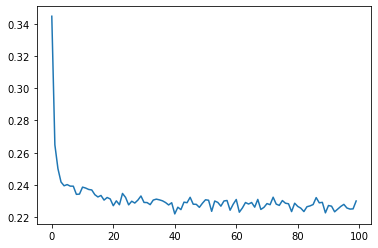

In [98]:
history = model.fit(X_train, y_train, epochs=100)
plt.plot(history.history['loss'])
print("\n\nL'accuracy ottenuta è: {}".format(history.history['accuracy'][-1]))

Verifico se il mio sistema è in grado di "leggere" i dati esterni al training cioè se è in grado di eseguire per bene delle previsioni lato testing.

Verifichiamo l'accuracy del mio modello rispetto ai dati di test!

In [95]:
results = model.evaluate(
    tf.convert_to_tensor(label_X_test, np.float32),
    tf.convert_to_tensor(y_test, np.float32), 
    batch_size=128)

#Ti da la test Accuracy:

print('\nTest accuracy:', results[1])


12/12 [==============================] - 0s 2ms/step - loss: 0.2046 - accuracy: 0.7984

Test accuracy: 0.7984386086463928
